In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, mannwhitneyu, describe, skew, bootstrap
from scipy.special import softmax
from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import interp1d

##sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

from tsfresh.feature_extraction.feature_calculators import mean_change, number_peaks, mean_n_absolute_max

import pywt
import seaborn as sns

## tensorflow
import tensorflow as tf
from tensorflow.keras import backend as K

## Raman tools
import Raman_tools as rt

###vanilla grads
import VanillaGrad as vgs

import sys
sys.path.append('/Users/pinguino/Documents/Layer-Wise Relevance Propagation')
import Layer_Wise_Propagation as lwp
sys.path.append('/Users/pinguino/Documents/Deconvnet_CRP')
import ICUAI_OCM as ocm
sys.path.append('/Users/pinguino/Documents/ENSO')
import ENSO_ccn as cnn
import SMOE
import ENSOutils as utils

import itertools

### type, if CENTRO or RING
chunk= 'CHgroup_Ratinonal'

/opt/anaconda3/envs/ENSO/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/envs/ENSO/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [6]:
def split_string(string):
    ff = np.array([char_ for char_ in string])
    ff=='-'
    string_markpoint= np.where(ff=='-')[0][0]
    return string[0:string_markpoint], string[string_markpoint+1:]


def global_rescaling(X):
    Xmax, Xmin = X.max(), X.min()
    A = 1/(Xmax-Xmin)
    B = -(Xmax+Xmin)/(Xmax-Xmin)
    return A*X+B

def prepeare_data(X1, X2):
    X = np.vstack([X1, X2])
    X = rt.savgol_filt(X) ##apply savgol filter
    X = np.expand_dims(X, axis= 2)
    Y = np.hstack([np.zeros(X1.shape[0]), np.ones(X2.shape[0])])
    return X, Y

In [7]:
def mean_roc(ROCs):
    T = np.linspace(0, 1, 1000)
    box = []
    for item in range(len(ROCs)):
        fpr_, tpr_ = ROCs[item][0], ROCs[item][1]
        xx = np.clip(fpr_, a_min=1e-10, a_max=1-1e-10)
        yy = np.clip(tpr_, a_min=1e-10, a_max=1-1e-10)
        myroc = np.interp(x = T, 
                          xp= xx, 
                          fp= yy, 
                          left=0, right=1)
        
        

        box.append(myroc)
    
    return T, np.array(box).mean(axis= 0)

In [4]:
#### IMPORT DATA
###
path1 = 'diana-dati-tumorali_lug2022/melanoma_luglio2022/202207-HaCat.dat'
ld1 = pd.read_csv(path1, sep = '\t', index_col=False)
###
path2 = 'diana-dati-tumorali_lug2022/melanoma_luglio2022/202207-A375.dat'
ld2 = pd.read_csv(path2, sep = '\t', index_col=False)
###
path3 = 'diana-dati-tumorali_lug2022/melanoma_luglio2022/202207-SkMel28.dat'
ld3 = pd.read_csv(path3, sep = '\t', index_col=False)
###
path4 = 'diana-dati-tumorali_lug2022/colon_luglio2022/Ht29_terzo set.dat'
ld4 = pd.read_csv(path4, sep = '\t', index_col=False, decimal= ',')
###
path5 = 'diana-dati-tumorali_lug2022/colon_luglio2022/CaCO_terzo set.dat'
ld5 = pd.read_csv(path5, sep = '\t', index_col=False, decimal=',')
###
path6 = 'diana-dati-tumorali_lug2022/colon_luglio2022/Hacat_terzo set.dat'
ld6 = pd.read_csv(path1, sep = '\t', index_col=False)



########## load data - 1st region - peak 200cm^-1
xx1 = ld1.values[1:570 , 2:].T 
xx2 = ld2.values[1:570 , 2:].T
xx3 = ld3.values[1:570 , 2:].T
xx4 = ld4.values[1:570 , 2:].T
xx5 = ld5.values[1:570 , 2:].T
inverse_wavelenght = ld1.values[1:570 , 1]

#### #### #### #### ### #### ####
### Skimming the data, remove spectra whose wavelenghts show at least one outlier intensity. 
xx1 = rt.skim_instances(xx1, standardize=False)
xx2 = rt.skim_instances(xx2, standardize=False)
xx3 = rt.skim_instances(xx3, standardize=False)
xx4 = rt.skim_instances(xx4, standardize=False)
xx5 = rt.skim_instances(xx5, standardize=False)

###resort data respect to the inverse_wavelenght
new_indexing = np.argsort(inverse_wavelenght)
inverse_wavelenght = inverse_wavelenght[new_indexing]
xx1 = xx1[:, new_indexing]
xx2 = xx2[:, new_indexing]
xx3 = xx3[:, new_indexing]
xx4 = xx4[:, new_indexing]
xx5 = xx5[:, new_indexing]

In [5]:
def report(x1, x2, cod, 
           nfilt_=16,
           ks_ = 3,
           dropout_= 25e-2,
           deepness_ = 10, 
           lr_ = 5e-4,
           actv_ = 'softplus',
           batch_size_ = 64,
           patience_ = 5,
           shifts_loc= inverse_wavelenght):
    
    ### detalils PCA & KFold Validation
    kfold = KFold(10, shuffle=True, random_state=32)
    ROCs= []
    AUCs = []
    CM = []
    SM0, SM1, SMG = [], [], []
    
    
    ###get labels as strings
    label1, label2 = split_string(cod)
    label_kol = {'HaCat':'tab:blue', 
                  'A375':'tab:red', 
                  'SkMel28':'tab:green', 
                   'HT29':'tab:red', 
                  'CaCO':'tab:green'}
    
    label_softkol = {'HaCat':0, 
                      'A375':4, 
                      'SkMel28':2, 
                      'HT29':4, 
                      'CaCO':2,
                    }
    
    label_kol_global = {'HaCat-A375':'tab:purple', 
                          'A375-SkMel28':'tab:orange', 
                          'HaCat-SkMel28':'tab:brown', 
                        'HaCat-HT29':'tab:purple', 
                          'HT29-CaCO':'tab:orange', 
                          'HaCat-CaCO':'tab:brown', 
                          }
    label_softkol_global = {'HaCat-A375':8, 
                          'A375-SkMel28':6, 
                          'HaCat-SkMel28':10,
                            'HaCat-HT29':8,
                           'HT29-CaCO':6, 
                          'HaCat-CaCO':10,  
                            }

    X, Y = prepeare_data(x1, x2)
    for index_train, index_test in kfold.split(X):

        ### Train-Test split
        Xtrain, Xtest = X[index_train], X[index_test]
        Ytrain, Ytest = Y[index_train], Y[index_test]

        ###
        deepness_ = np.clip(deepness_, a_max=int(np.log2((1680-ks_+1)/ks_)), a_min= 1)

        ### fitting of the model
        model_cnn, hist = lwp.cnn_rational(Xtrain = Xtrain, Ytrain = Ytrain, 
                                   Xtest= Xtest, Ytest= Ytest,
                                   nfilt= nfilt_,
                                   actv1= actv_,                       
                                   padding= 'valid',
                                   ks = ks_,
                                   DropOut= dropout_, 
                                   GDropout= False, 
                                   deepness = deepness_,
                                   patience= patience_,
                                   pred_stddev=0,
                                   Verbose=0, 
                                   lr= lr_, 
                                   second_layer= True, 
                                   batch_size= batch_size_, 
                                   unit_second_layer = 16,
                                   winit = 1e-1, 
                                   Epochs= 100, 
                                   platt = False,
                                   bias= True, 
                                   display_summary= False)

        
        ### ### ### ### ### ### ### ### ###
        Ypred = model_cnn.predict(Xtest)
        theta0 = utils.best_theshold_cnn(Ytest, Ypred.ravel())
        auc_ = np.maximum(.5, roc_auc_score(y_true= Ytest, y_score= Ypred.ravel()).round(2))
        print(auc_)
        fpr_, trp_, _ = roc_curve(y_true= Ytest, y_score= Ypred.ravel())
        cm_ = confusion_matrix(y_true=Ytest, y_pred= (Ypred.ravel()>theta0).astype(int), normalize='all')
        AUCs.append(np.clip(auc_, a_min=.5, a_max=.99))
        ROCs.append([fpr_, trp_])
        CM.append(cm_)
        
        #### get saliency
        sal0 = vgs.explain_score_model(Xtest[Ytest==0], model= model_cnn)
        sal0 = savgol_filter(sal0, window_length= 89, polyorder= 3)
        sal1 = vgs.explain_score_model(Xtest[Ytest==1], model= model_cnn)
        sal1 = savgol_filter(sal1, window_length= 89, polyorder= 3)
        sal_global = vgs.explain_score_model(Xtest, model= model_cnn)
        sal_global = savgol_filter(sal_global, window_length= 89, polyorder= 3)
        SMG.append(sal_global)
        SM0.append(sal0)
        SM1.append(sal1)
        
        
    ##########
    ### plot AUC
    TT, m0 = mean_roc(ROCs)
    plt.plot(TT, m0, c= 'black', label= 'AUC:'+str(np.mean(AUCs).round(2))+'±'+str(np.maximum(1e-2, sem(AUCs).round(2))))
    plt.plot([0, 1], [0, 1], ls= '--', color= 'black')
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.grid(True)
    plt.legend()
    plt.savefig('imgs_diana_sep2022_CNN/'+chunk+cod+'_CNN_ROC_AUC.png')
    roc_df = pd.DataFrame(np.array([TT, m0]).T)
    roc_df.to_csv('/Users/pinguino/Documents/Raman Spectra/imgs_articolo/'+cod+'ROC_CNN_alto.csv', header=False, index=False, index_label=False)
    plt.show()

    ### plot Confusion MAtrix
    plt.figure(1, figsize=(7, 7))
    plt.title('AUC:'+str( np.mean(AUCs).round(2))+'±'+str(np.maximum(1e-2, sem(AUCs).round(2))), fontsize= 16)
    df_ = pd.DataFrame(np.array(CM).mean(axis= 0), columns=[['True', 'False']])
    df_ = df_.set_index([['True', 'False']])
    sns.heatmap(df_, cmap= 'flare', vmin=0, vmax=1, annot=True, annot_kws={"size": 14})
    plt.xlabel('Ground truth', fontsize= 14)
    plt.ylabel('Estimated targets', fontsize= 14)
    plt.savefig('imgs_diana_sep2022_CNN/'+chunk+cod+'_CNN_ConfMtx.png')
    plt.show()
    
    
    ##SaliencyMaps
    ###plot LWP saliency maps
    SM0 = np.vstack(SM0)
    SM1 = np.vstack(SM1)
    SMG = np.vstack(SMG)
    print(SMG.shape)
    ###
    vg0 = np.quantile(SM0, [25e-2, 50e-2, 75e-2], axis= 0)
    vg1 = np.quantile(SM1, [25e-2, 50e-2, 75e-2], axis= 0)
    ### ### ###
    kolors = sns.color_palette('Paired')
    #shifts_loc = rt.meanpooling(shifts_loc, 21)
    plt.figure(2, figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(shifts_loc, vg0[1], c= kolors[label_softkol[label1]+1], label=label1)
    plt.ylabel('(VanillaGrad) Saliency')
    plt.fill_between(x= shifts_loc, y1=vg0[0], y2=vg0[2], color= kolors[label_softkol[label1]])
    plt.grid(True)
    plt.legend()
    ### ### ###
    plt.subplot(2, 1, 2)
    plt.plot(shifts_loc, vg1[1], c= kolors[label_softkol[label2]+1], label=label2)
    plt.ylabel('(VanillaGrad) Saliency')
    plt.xlabel('Raman Shifts [1/cm]')
    plt.fill_between(x= shifts_loc, y1=vg1[0], y2=vg1[2], color= kolors[label_softkol[label2]])
    plt.grid(True)
    plt.legend()
    #plt.savefig('imgs_diana_melanoma_lug2022_CNN/'+cod+'_sepClass_VanillaGrad.png')
    plt.show()
    #####
    plt.figure(2, figsize=(10, 5))
    plt.plot(shifts_loc, SM0.mean(axis= 0), c= label_kol[label1], label= label1)
    plt.plot(shifts_loc, SM1.mean(axis= 0), c= label_kol[label2], label= label2)
    plt.ylabel('(VanillaGrad) Saliency Map')
    plt.xlabel('Raman Shifts [1/cm]')
    plt.grid(True)
    plt.legend()
    #plt.savefig('imgs_diana_melanoma_lug2022_CNN/'+cod+'_VanillaGrad.png')
    plt.show()
    
    #####global
    plt.figure(3, figsize=(10, 5))
    zm = SMG.mean(axis= 0)
    zs = np.maximum(5e-3, sem(SMG, axis= 0))
    cl, cu = zm-1.96*zs, zm+1.96*zs
    plt.plot(shifts_loc, zm, c= label_kol_global[cod], label= cod)
    plt.fill_between(x= shifts_loc, y1=cl, y2=cu, color= kolors[label_softkol_global[cod]])
    plt.ylabel('(VanillaGrad) Saliency Map')
    plt.xlabel('Raman Shifts [1/cm]')
    plt.grid(True)
    plt.legend()
    plt.savefig('imgs_diana_sep2022_CNN/'+chunk+cod+'_VanillaGrad_global.png')
    plt.show()
    
    plt.figure(4, figsize=(10, 5))
    # compute CI
    
    CI_ = []
    for nn in range(0, SMG.shape[1]):
        boostrap_res= bootstrap((SMG[:, nn].ravel(),) , np.mean, n_resamples=100)
        CI_.append([boostrap_res.confidence_interval[0], boostrap_res.confidence_interval[1]])
        
    CI_ = np.array(CI_)
    zm= SMG.mean(axis= 0)
    plt.plot(shifts_loc, zm, color= 'black')
    plt.fill_between(x= shifts_loc, y1=CI_[:, 0], y2=CI_[:, 1], color= 'lightgray')
    plt.ylabel('(VanillaGrad) Saliency Map')
    plt.xlabel('Raman Shifts [1/cm]')
    plt.grid(True)
    plt.savefig('imgs_diana_sep2022_CNN/'+chunk+cod+'_VanillaGrad_global_CI_Gray.png')
    dgigio= pd.DataFrame(data= np.vstack((shifts_loc, zm, CI_[:, 0], CI_[:, 1])).T)
    dgigio.to_csv('imgs_diana_sep2022_CNN/'+chunk+cod+'_VanillaGrad_global_CI_Gray.csv', 
                  index= False, index_label=False)
    plt.show()
    
    return

# HaCat-A375

0.96
0.98
0.97
0.96
0.94
0.98
0.95
0.97
0.95
0.94


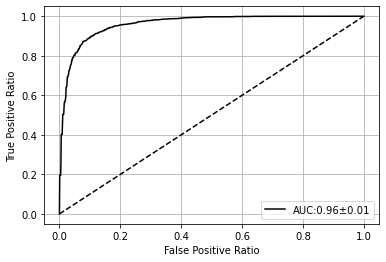

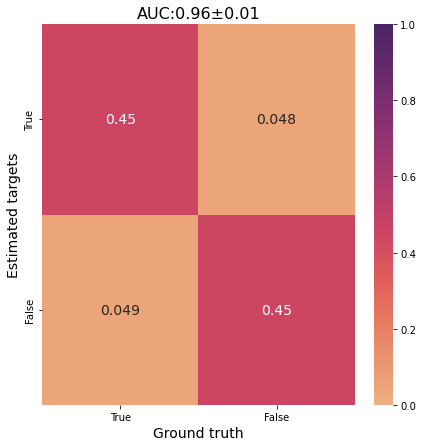

(3981, 569)


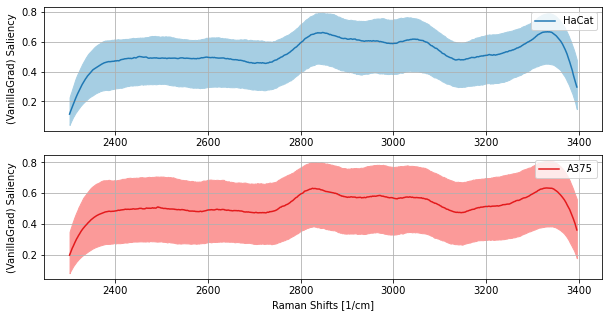

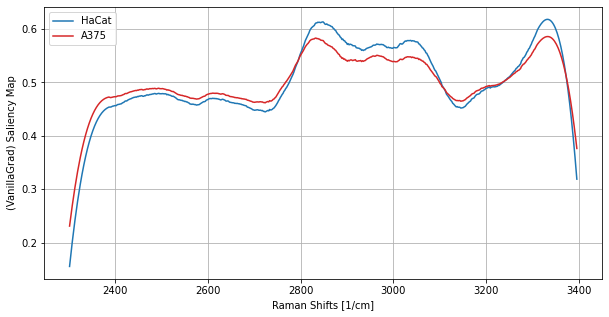

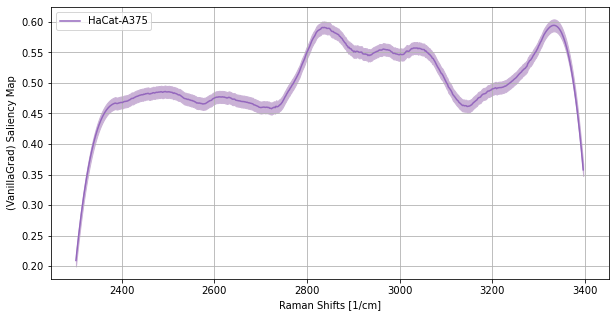

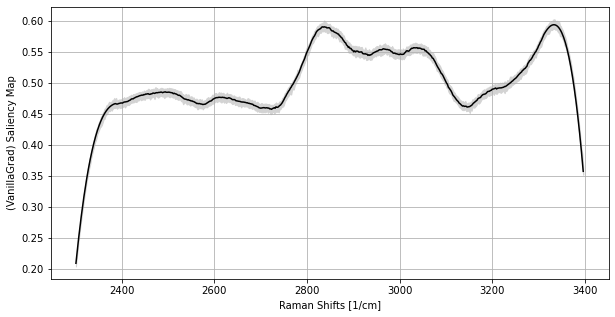

In [6]:
report(xx1, xx2, 'HaCat-A375', dropout_=25e-2, actv_='linear', ks_= 17, nfilt_= 4, lr_= 5e-4, deepness_= 2, patience_= 5)

# HaCat-SkMel28

0.99
1.0
0.99
0.99
0.99
0.99
1.0
0.99
0.99
0.99


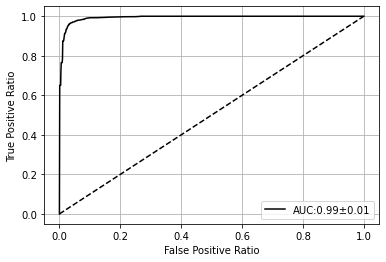

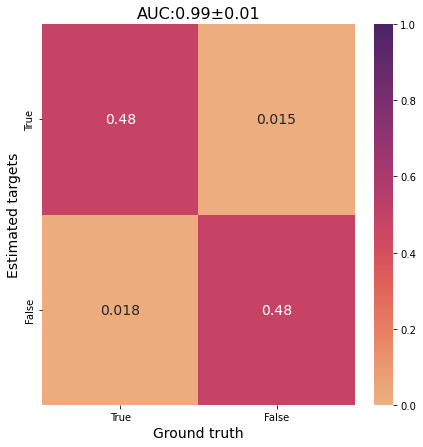

(3979, 569)


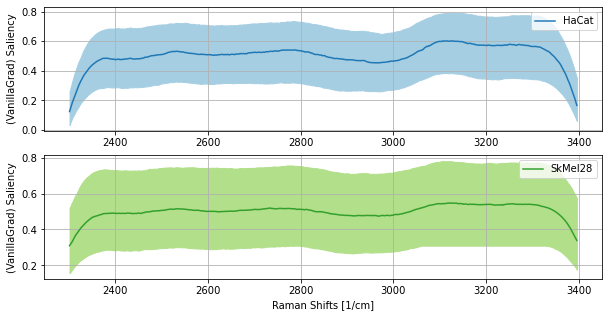

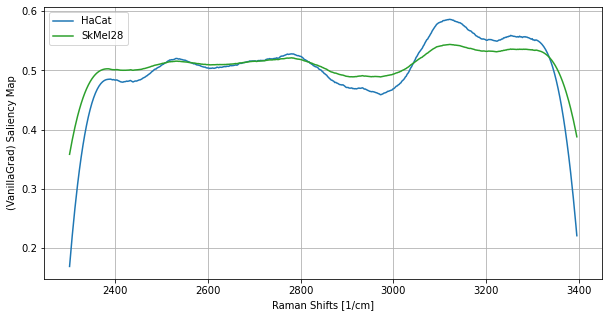

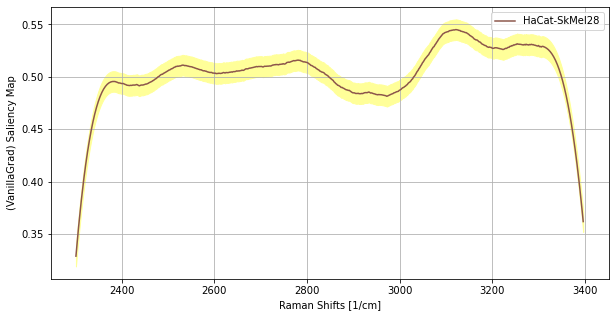

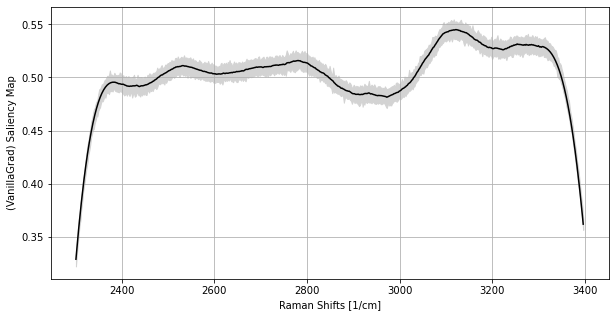

In [7]:
report(xx1, xx3, 'HaCat-SkMel28', dropout_=25e-2, actv_='linear', ks_= 17, nfilt_= 4, lr_= 5e-4, deepness_= 2, patience_= 5)

# A375-SkMel28

0.98
0.98
0.98
1.0
1.0
0.98
0.99
0.99
0.99
0.98


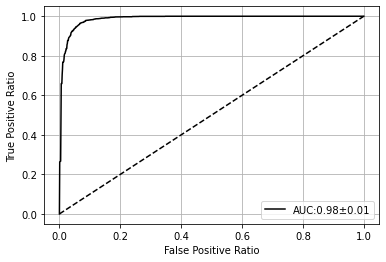

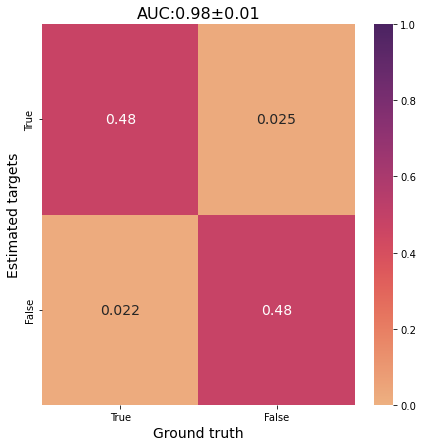

(3994, 569)


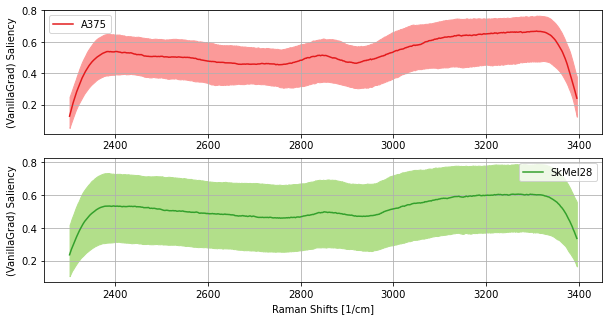

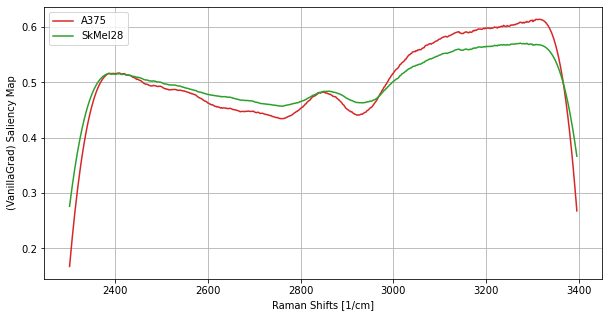

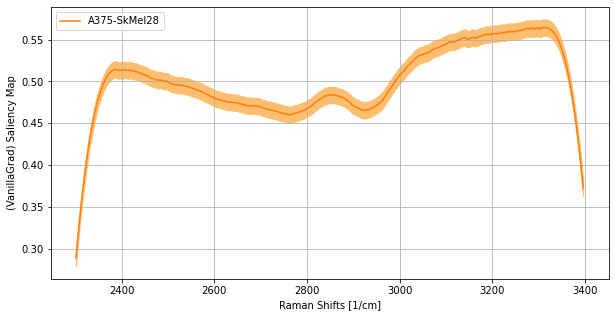

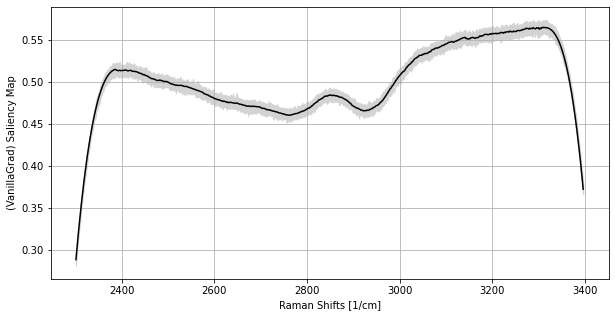

In [8]:
report(xx2, xx3, 'A375-SkMel28', dropout_=25e-2, actv_='linear', ks_= 17, nfilt_= 4, lr_= 5e-4, deepness_= 2, patience_= 5)

# HaCat-HT29

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


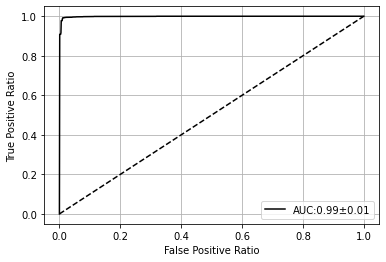

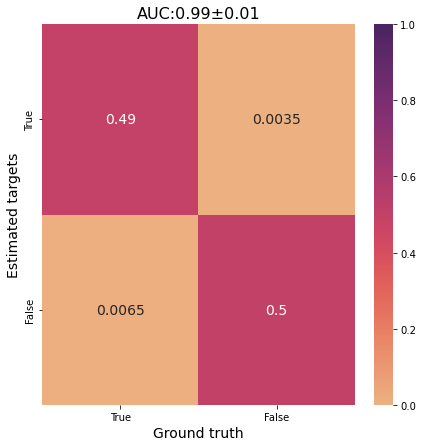

(4003, 569)


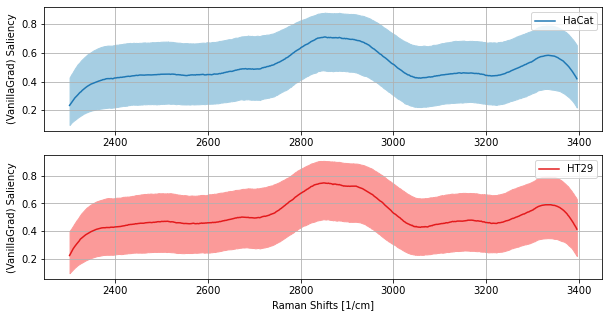

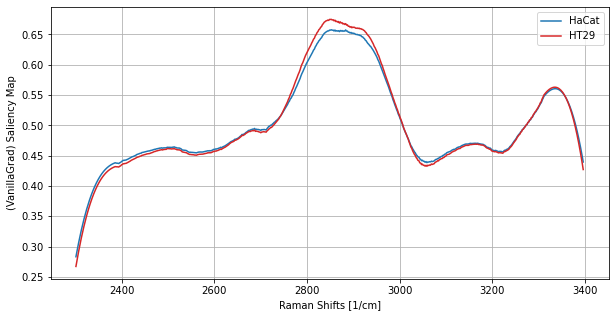

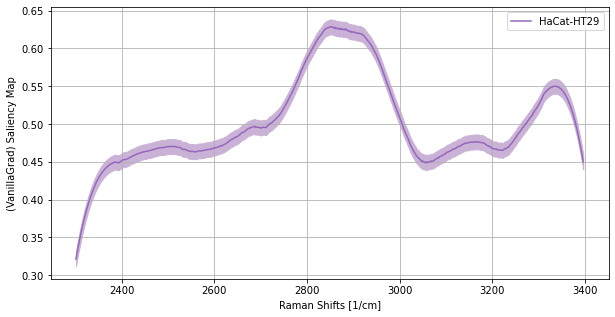

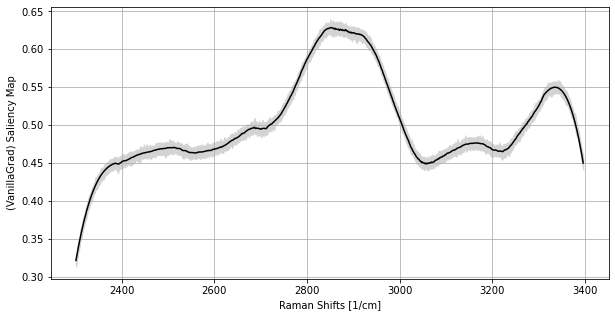

In [9]:
report(xx1, xx4, 'HaCat-HT29', dropout_=25e-2, actv_='linear', ks_= 17, nfilt_= 4, lr_= 5e-4, deepness_= 2, patience_= 5)

# HaCat-CaCO

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


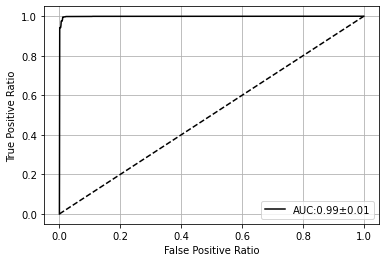

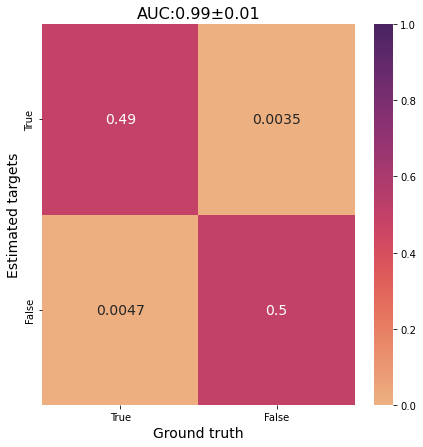

(4003, 569)


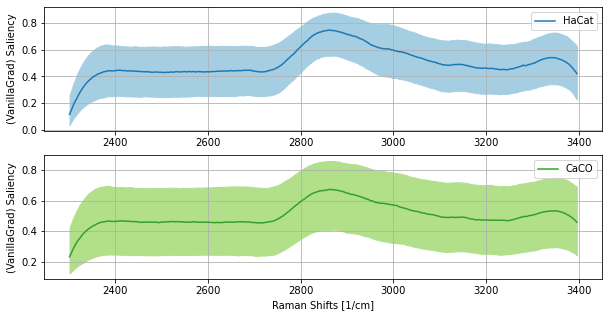

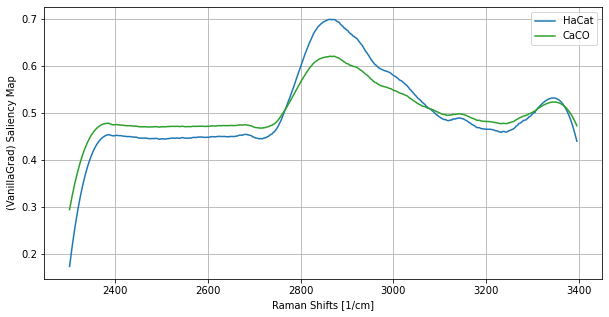

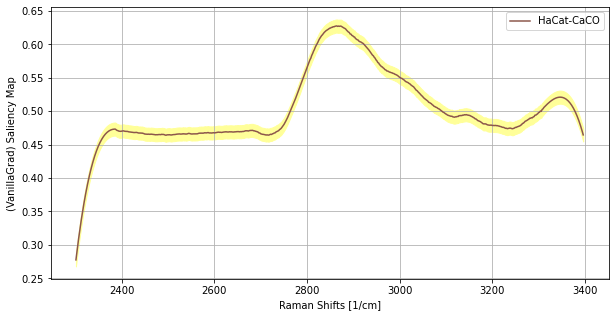

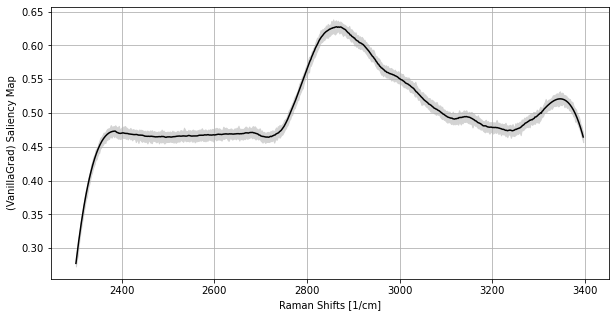

In [10]:
report(xx1, xx5, 'HaCat-CaCO', dropout_=25e-2, actv_='linear', ks_= 17, nfilt_= 4, lr_= 5e-4, deepness_= 2, patience_= 5)

# HT29-CaCO 

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


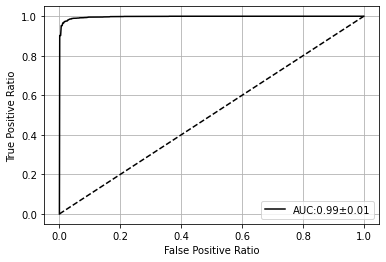

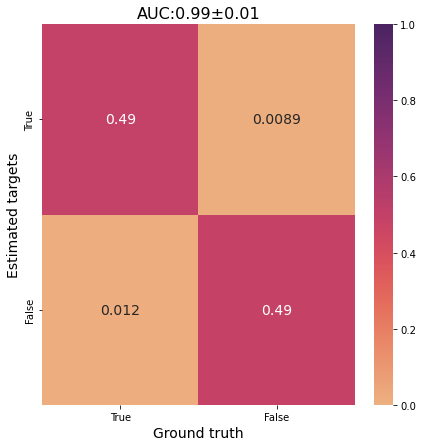

(4040, 569)


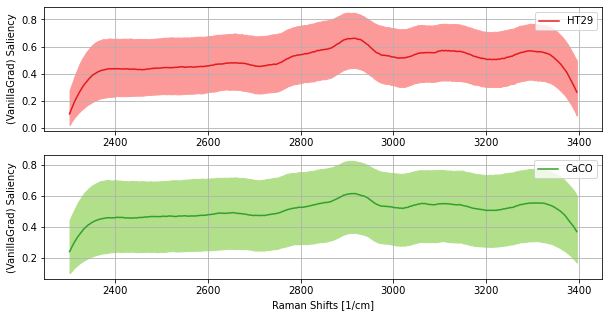

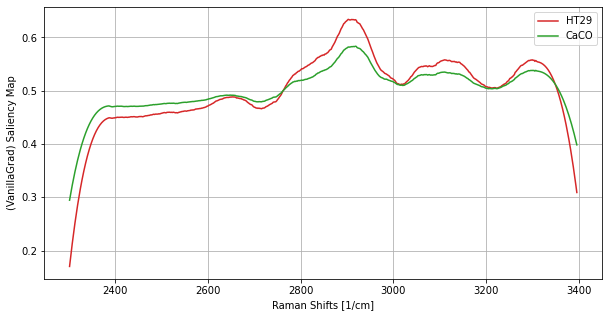

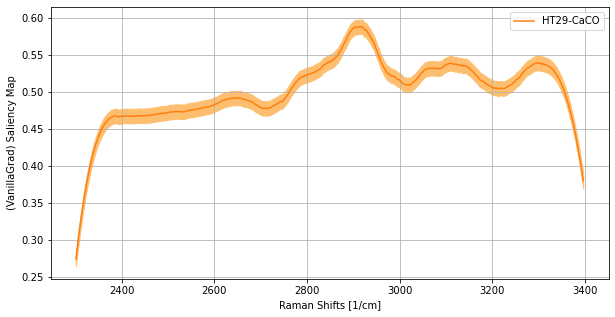

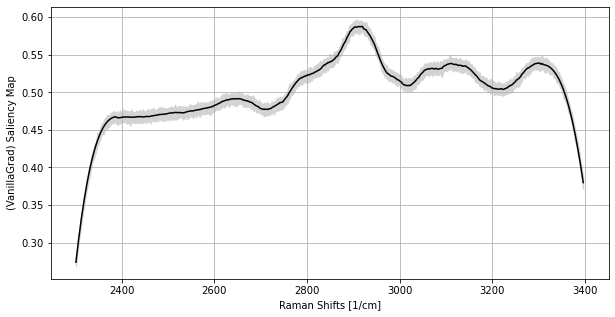

In [11]:
report(xx4, xx5, 'HT29-CaCO', dropout_=25e-2, actv_='linear', ks_= 17, nfilt_= 4, lr_= 5e-4, deepness_= 2, patience_= 5)

In [46]:
#### IMPORT DATA
###
path1 = 'diana-dati-tumorali_lug2022/melanoma_luglio2022/202207-HaCat.dat'
ld1 = pd.read_csv(path1, sep = '\t', index_col=False)
###
path2 = 'diana-dati-tumorali_lug2022/melanoma_luglio2022/202207-A375.dat'
ld2 = pd.read_csv(path2, sep = '\t', index_col=False)
###
path3 = 'diana-dati-tumorali_lug2022/melanoma_luglio2022/202207-SkMel28.dat'
ld3 = pd.read_csv(path3, sep = '\t', index_col=False)
###
path4 = 'diana-dati-tumorali_lug2022/colon_luglio2022/Ht29_terzo set.dat'
ld4 = pd.read_csv(path4, sep = '\t', index_col=False, decimal= ',')
###
path5 = 'diana-dati-tumorali_lug2022/colon_luglio2022/CaCO_terzo set.dat'
ld5 = pd.read_csv(path5, sep = '\t', index_col=False, decimal=',')
###
path6 = 'diana-dati-tumorali_lug2022/colon_luglio2022/Hacat_terzo set.dat'
ld6 = pd.read_csv(path1, sep = '\t', index_col=False)



########## load data - 1st region - peak 200cm^-1
xx1 = ld1.values[1:570 , 2:].T 
xx2 = ld2.values[1:570 , 2:].T
xx3 = ld3.values[1:570 , 2:].T
xx4 = ld4.values[1:570 , 2:].T
xx5 = ld5.values[1:570 , 2:].T
inverse_wavelenght = ld1.values[1:570 , 1]

#### #### #### #### ### #### ####
### Skimming the data, remove spectra whose wavelenghts show at least one outlier intensity. 
xx1 = rt.skim_instances(xx1, standardize=True, std_=False)
xx2 = rt.skim_instances(xx2,  standardize=True, std_=False)
xx3 = rt.skim_instances(xx3,  standardize=True, std_=False)
xx4 = rt.skim_instances(xx4,  standardize=True, std_=False)
xx5 = rt.skim_instances(xx5,  standardize=True, std_=False)

###resort data respect to the inverse_wavelenght
new_indexing = np.argsort(inverse_wavelenght)
inverse_wavelenght = inverse_wavelenght[new_indexing]
xx1 = xx1[:, new_indexing]
xx2 = xx2[:, new_indexing]
xx3 = xx3[:, new_indexing]
xx4 = xx4[:, new_indexing]
xx5 = xx5[:, new_indexing]

In [51]:
def report_zeromean(x1, x2, cod, 
           nfilt_=16,
           ks_ = 3,
           dropout_= 25e-2,
           deepness_ = 10, 
           lr_ = 5e-4,
           actv_ = 'softplus',
           batch_size_ = 64,
           patience_ = 5,
           shifts_loc= inverse_wavelenght):
    
    ### detalils PCA & KFold Validation
    kfold = KFold(10, shuffle=True, random_state=32)
    ROCs= []
    AUCs = []
    CM = []
    SM0, SM1, SMG = [], [], []
    
    
    ###get labels as strings
    label1, label2 = split_string(cod)
    label_kol = {'HaCat':'tab:blue', 
                  'A375':'tab:red', 
                  'SkMel28':'tab:green', 
                   'HT29':'tab:red', 
                  'CaCO':'tab:green'}
    
    label_softkol = {'HaCat':0, 
                      'A375':4, 
                      'SkMel28':2, 
                      'HT29':4, 
                      'CaCO':2,
                    }
    
    label_kol_global = {'HaCat-A375':'tab:purple', 
                          'A375-SkMel28':'tab:orange', 
                          'HaCat-SkMel28':'tab:brown', 
                        'HaCat-HT29':'tab:purple', 
                          'HT29-CaCO':'tab:orange', 
                          'HaCat-CaCO':'tab:brown', 
                          }
    label_softkol_global = {'HaCat-A375':8, 
                          'A375-SkMel28':6, 
                          'HaCat-SkMel28':10,
                            'HaCat-HT29':8,
                           'HT29-CaCO':6, 
                          'HaCat-CaCO':10,  
                            }

    X, Y = prepeare_data(x1, x2)
    for index_train, index_test in kfold.split(X):

        ### Train-Test split
        Xtrain, Xtest = X[index_train], X[index_test]
        Ytrain, Ytest = Y[index_train], Y[index_test]

        ###
        deepness_ = np.clip(deepness_, a_max=int(np.log2((1680-ks_+1)/ks_)), a_min= 1)

        ### fitting of the model
        model_cnn, hist = lwp.cnn_(Xtrain = Xtrain, Ytrain = Ytrain, 
                                   Xtest= Xtest, Ytest= Ytest,
                                   nfilt= nfilt_,
                                   actv1= actv_,                       
                                   padding= 'valid',
                                   ks = ks_,
                                   DropOut= dropout_, 
                                   GDropout= False, 
                                   deepness = deepness_,
                                   patience= patience_,
                                   pred_stddev=0,
                                   Verbose=0, 
                                   lr= lr_, 
                                   second_layer= True, 
                                   batch_size= batch_size_, 
                                   unit_second_layer = 16,
                                   winit = 1e-1, 
                                   Epochs= 100, 
                                   platt = False,
                                   bias= True, 
                                   display_summary= False)

        
        ### ### ### ### ### ### ### ### ###
        Ypred = model_cnn.predict(Xtest)
        theta0 = utils.best_theshold_cnn(Ytest, Ypred.ravel())
        auc_ = np.maximum(.5, roc_auc_score(y_true= Ytest, y_score= Ypred.ravel()).round(2))
        print(auc_)
        fpr_, trp_, _ = roc_curve(y_true= Ytest, y_score= Ypred.ravel())
        cm_ = confusion_matrix(y_true=Ytest, y_pred= (Ypred.ravel()>theta0).astype(int), normalize='all')
        AUCs.append(np.clip(auc_, a_min=.5, a_max=.99))
        ROCs.append([fpr_, trp_])
        CM.append(cm_)
        
        #### get saliency
        sal0 = vgs.explain_score_model(Xtest[Ytest==0], model= model_cnn)
        sal0 = savgol_filter(sal0, window_length= 89, polyorder= 3)
        sal1 = vgs.explain_score_model(Xtest[Ytest==1], model= model_cnn)
        sal1 = savgol_filter(sal1, window_length= 89, polyorder= 3)
        sal_global = vgs.explain_score_model(Xtest, model= model_cnn)
        sal_global = savgol_filter(sal_global, window_length= 89, polyorder= 3)
        SMG.append(sal_global)
        SM0.append(sal0)
        SM1.append(sal1)
        
        
    ##########
    ### plot AUC
    TT, m0 = mean_roc(ROCs)
    plt.plot(TT, m0, c= 'black', label= 'AUC:'+str(np.mean(AUCs).round(2))+'±'+str(np.maximum(1e-2, sem(AUCs).round(2))))
    plt.plot([0, 1], [0, 1], ls= '--', color= 'black')
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.grid(True)
    plt.legend()
    plt.savefig('imgs_diana_sep2022_CNN/'+chunk+cod+'_CNN_ROC_AUC.png')
    roc_df = pd.DataFrame(np.array([TT, m0]).T)
    roc_df.to_csv('/Users/pinguino/Documents/Raman Spectra/imgs_articolo/'+cod+'ROC_CNN_alto.csv', header=False, index=False, index_label=False)
    plt.show()

    ### plot Confusion MAtrix
    plt.figure(1, figsize=(7, 7))
    plt.title('AUC:'+str( np.mean(AUCs).round(2))+'±'+str(np.maximum(1e-2, sem(AUCs).round(2))), fontsize= 16)
    df_ = pd.DataFrame(np.array(CM).mean(axis= 0), columns=[['True', 'False']])
    df_ = df_.set_index([['True', 'False']])
    sns.heatmap(df_, cmap= 'flare', vmin=0, vmax=1, annot=True, annot_kws={"size": 14})
    plt.xlabel('Ground truth', fontsize= 14)
    plt.ylabel('Estimated targets', fontsize= 14)
    plt.savefig('imgs_diana_sep2022_CNN/'+chunk+cod+'_CNN_ConfMtx.png')
    plt.show()
    
    
    ##SaliencyMaps
    ###plot LWP saliency maps
    SM0 = np.vstack(SM0)
    SM1 = np.vstack(SM1)
    SMG = np.vstack(SMG)
    print(SMG.shape)
    ###
    vg0 = np.quantile(SM0, [25e-2, 50e-2, 75e-2], axis= 0)
    vg1 = np.quantile(SM1, [25e-2, 50e-2, 75e-2], axis= 0)
    ### ### ###
    kolors = sns.color_palette('Paired')
    #shifts_loc = rt.meanpooling(shifts_loc, 21)
    plt.figure(2, figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(shifts_loc, vg0[1], c= kolors[label_softkol[label1]+1], label=label1)
    plt.ylabel('(VanillaGrad) Saliency')
    plt.fill_between(x= shifts_loc, y1=vg0[0], y2=vg0[2], color= kolors[label_softkol[label1]])
    plt.grid(True)
    plt.legend()
    ### ### ###
    plt.subplot(2, 1, 2)
    plt.plot(shifts_loc, vg1[1], c= kolors[label_softkol[label2]+1], label=label2)
    plt.ylabel('(VanillaGrad) Saliency')
    plt.xlabel('Raman Shifts [1/cm]')
    plt.fill_between(x= shifts_loc, y1=vg1[0], y2=vg1[2], color= kolors[label_softkol[label2]])
    plt.grid(True)
    plt.legend()
    #plt.savefig('imgs_diana_melanoma_lug2022_CNN/'+cod+'_sepClass_VanillaGrad.png')
    plt.show()
    #####
    plt.figure(2, figsize=(10, 5))
    plt.plot(shifts_loc, SM0.mean(axis= 0), c= label_kol[label1], label= label1)
    plt.plot(shifts_loc, SM1.mean(axis= 0), c= label_kol[label2], label= label2)
    plt.ylabel('(VanillaGrad) Saliency Map')
    plt.xlabel('Raman Shifts [1/cm]')
    plt.grid(True)
    plt.legend()
    #plt.savefig('imgs_diana_melanoma_lug2022_CNN/'+cod+'_VanillaGrad.png')
    plt.show()
    
    #####global
    plt.figure(3, figsize=(10, 5))
    zm = SMG.mean(axis= 0)
    zs = np.maximum(5e-3, sem(SMG, axis= 0))
    cl, cu = zm-1.96*zs, zm+1.96*zs
    plt.plot(shifts_loc, zm, c= label_kol_global[cod], label= cod)
    plt.fill_between(x= shifts_loc, y1=cl, y2=cu, color= kolors[label_softkol_global[cod]])
    plt.ylabel('(VanillaGrad) Saliency Map')
    plt.xlabel('Raman Shifts [1/cm]')
    plt.grid(True)
    plt.legend()
    plt.savefig('imgs_diana_sep2022_CNN/'+chunk+cod+'_VanillaGrad_global.png')
    plt.show()
    
    plt.figure(4, figsize=(10, 5))
    # compute CI
    
    CI_ = []
    for nn in range(0, SMG.shape[1]):
        boostrap_res= bootstrap((SMG[:, nn].ravel(),) , np.mean, n_resamples=100)
        CI_.append([boostrap_res.confidence_interval[0], boostrap_res.confidence_interval[1]])
        
    CI_ = np.array(CI_)
    zm= SMG.mean(axis= 0)
    plt.plot(shifts_loc, zm, color= 'black')
    plt.fill_between(x= shifts_loc, y1=CI_[:, 0], y2=CI_[:, 1], color= 'lightgray')
    plt.ylabel('(VanillaGrad) Saliency Map')
    plt.xlabel('Raman Shifts [1/cm]')
    plt.grid(True)
    plt.savefig('imgs_diana_sep2022_CNN/'+chunk+cod+'_VanillaGrad_global_CI_Rational_ZeroMean.png')
    dgigio= pd.DataFrame(data= np.vstack((shifts_loc, zm, CI_[:, 0], CI_[:, 1])).T)
    dgigio.to_csv('imgs_diana_sep2022_CNN/'+chunk+cod+'_VanillaGrad_global_CI_Rational_ZeroMean.csv', 
                  index= False, index_label=False)
    plt.show()
    
    
    #######
    ##PCA##
    #######
    
    pca=PCA(n_components=16)
    Xpca = pca.fit_transform(X[:, :, 0])
    auc_lr =[]
    for train_index, test_index in kfold.split(Xpca):
        Xtrain_, Xtest_ = Xpca[train_index], Xpca[test_index]
        Ytrain_, Ytest_ = Y[train_index], Y[test_index]
        lr= LogisticRegression()
        lr.fit(Xtrain_, Ytrain_)
        auc__ = roc_auc_score(y_score=lr.decision_function(Xtest_), y_true= Ytest_)
        auc_lr.append(auc__)
        
    print('AUC PCA-LR:', np.mean(auc_lr).round(2), '±', sem(auc_lr).round(2))
    print('Explained Variance:', pca.explained_variance_ratio_[0:4])
    dgigio_PCA = pd.DataFrame(np.vstack((shifts_loc, pca.components_[0:4])).T)
    dgigio_PCA.to_csv('imgs_diana_sep2022_CNN/'+chunk+cod+'_PCA_Loadings_CI_Rational_ZeroMean.csv', 
                  index= False, index_label=False)
    
    
    print('**********')
    print('**********')
    print('**********')
    return

0.99
0.99
0.98
0.97
0.99
0.98
0.99
0.98
0.99
0.98


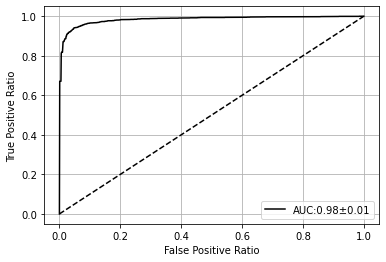

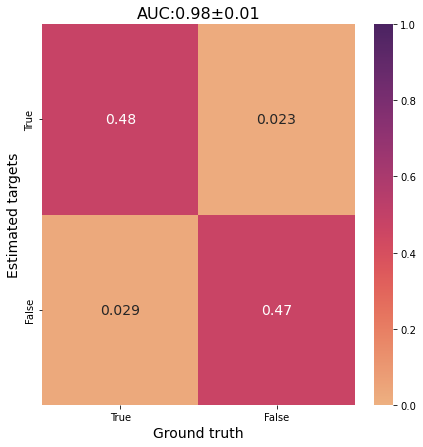

(3542, 569)


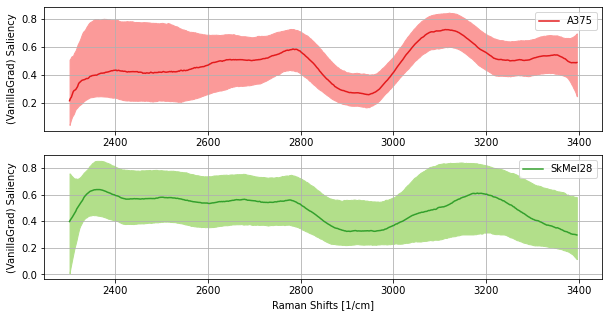

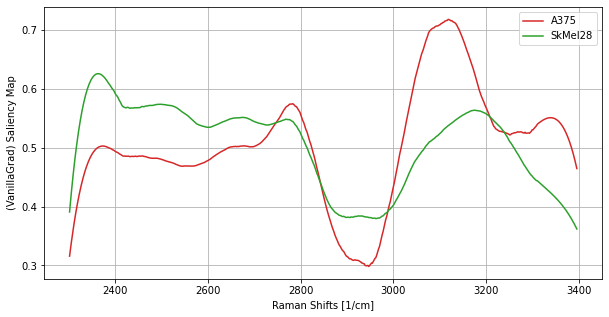

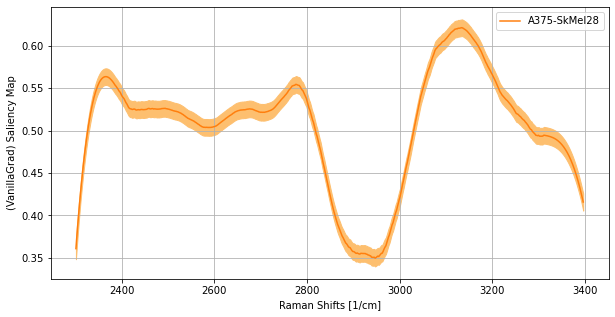

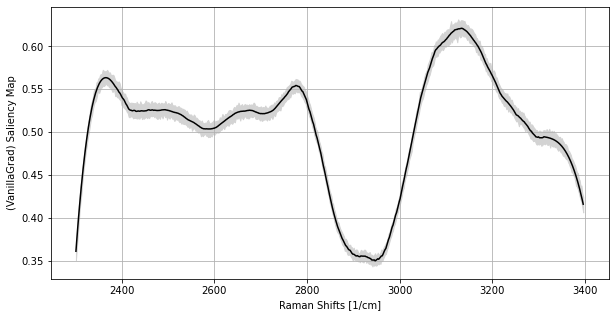

AUC PCA-LR: 0.99 ± 0.0
Explained Variance: [0.72246774 0.1581481  0.02951911 0.01064964]
**********
**********
**********
1.0
0.99
0.98
0.99
0.99
0.99
0.99
0.99
0.99
1.0


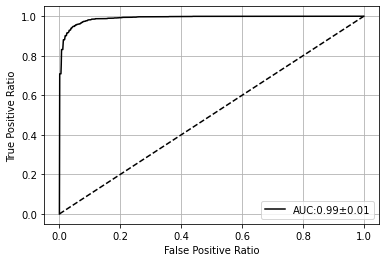

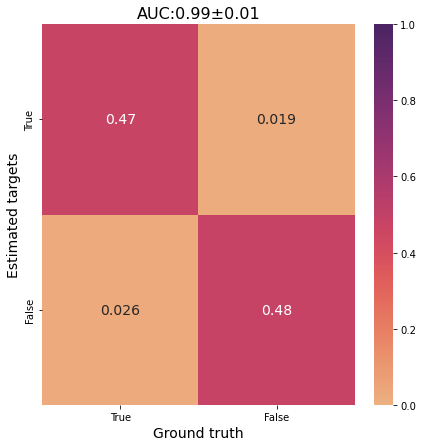

(3411, 569)


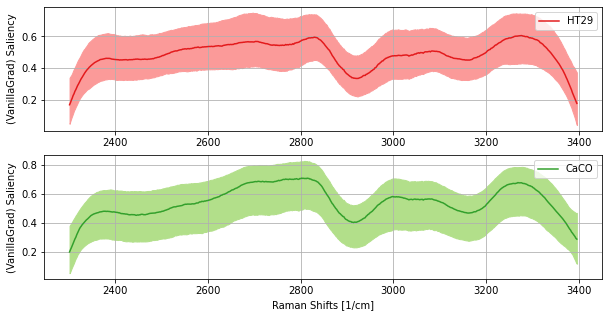

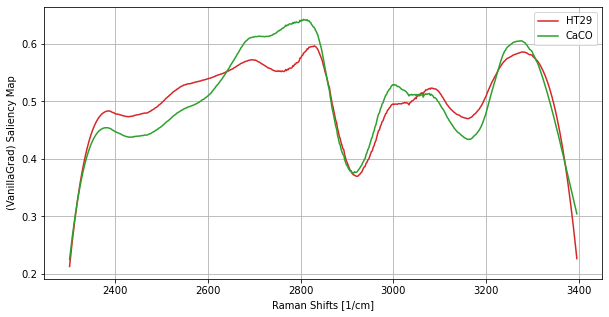

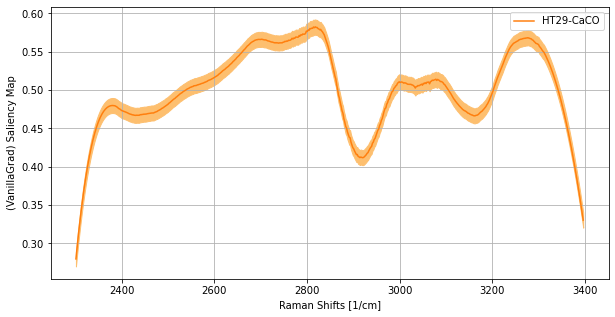

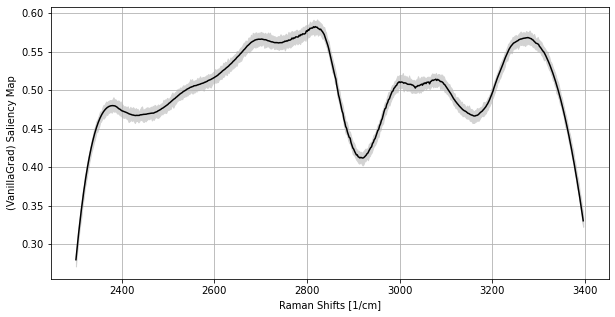

AUC PCA-LR: 1.0 ± 0.0
Explained Variance: [0.69100167 0.17042928 0.03037042 0.01787089]
**********
**********
**********


In [53]:
report_zeromean(xx2, xx3, 'A375-SkMel28', dropout_=25e-2, actv_='relu', ks_= 3, nfilt_= 16, lr_= 5e-4, deepness_= 4, patience_= 3)
report_zeromean(xx4, xx5, 'HT29-CaCO', dropout_=25e-2, actv_='relu', ks_= 3, nfilt_= 16, lr_= 5e-4, deepness_= 4, patience_= 3)